In [275]:
import os
import imageio as imageio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ml
import sklearn.preprocessing as pre


In [125]:
from PIL import Image
cancer_dataset = pd.read_csv("../datasets/cancer.csv")
cancer_labels = [1 if val == 'M' else -1 for val in cancer_dataset['label'].values]
cancer_points = cancer_dataset.drop(['label'], axis=1).values

cancer_points = pre.MinMaxScaler().fit_transform(cancer_points)

cancer_points_training, cancer_points_test, cancer_labels_training, cancer_labels_test = ml.train_test_split(cancer_points, cancer_labels, train_size=0.8)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [126]:
spam_dataset = pd.read_csv("../datasets/spam.csv")
spam_labels = [val for val in spam_dataset['label'].values]
spam_points = spam_dataset.drop(['label'], axis=1).values

spam_points = pre.MinMaxScaler().fit_transform(spam_points)
spam_labels = (spam_labels == spam_labels[0]) * 2 - 1

spam_points_training, spam_points_test, spam_labels_training, spam_labels_test = ml.train_test_split(spam_points, spam_labels, train_size=0.8)



/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [205]:
def to_row(arr, size):
    return arr.reshape(size, 1)

def gradient(dim, train_size, weights, x_train, y_train): 
    return to_row( y_train / (1 + np.exp(y_train * (x_train @ weights).flatten())) @ x_train, dim) / train_size

def logistic_regression(x_train, x_test, y_train, y_test, eta, mini_batch=500, max_iter=500):
    dim = x_train.shape[1]
    train_size = x_train.shape[0]
    
    weights = np.random.rand(dim, 1)
    # with zeros started too good
    # weights = np.zeros((dim, 1))
    result_errors = list()
    prev_err = None
    for _ in range(max_iter):
        # Go per mini batch
        for start_ind in range(0, train_size, mini_batch):
            x_train_batch, y_train_batch = x_train[start_ind:start_ind + mini_batch], y_train[start_ind:start_ind + mini_batch]
            weights += eta * gradient(dim, train_size, weights, x_train_batch, y_train_batch)
                
        cur_err = np.sum(np.abs(np.sign(x_test @ weights).flatten() - y_test)) / 2
        if prev_err and prev_err < cur_err:
            break
        result_errors.append(cur_err)
        prev_err = cur_err
    return result_errors
    
def graph(err):
    plt.plot(err)
    plt.show()


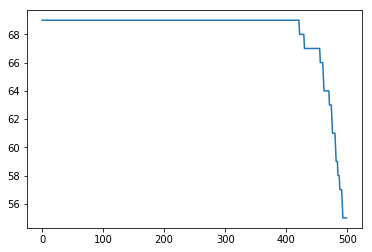

In [206]:
graph(logistic_regression(cancer_points_training, cancer_points_test, cancer_labels_training, cancer_labels_test, 0.01))


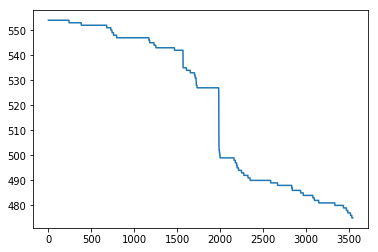

In [207]:
graph(logistic_regression(spam_points_training, spam_points_test, spam_labels_training, spam_labels_test, 0.01, 200, 5000))


In [209]:
#will use pytorch
import torch
import torch.nn as nn
import torch.optim as optim


In [211]:
mnist_dataset = pd.read_csv("../datasets/mnist.csv")
mnist_labels = mnist_dataset['label'].values
mnist_points = mnist_dataset.drop(['label'], axis=1).values.reshape(-1, 1, 28, 28)

# mnist_points = pre.MinMaxScaler().fit_transform(mnist_points)

mnist_points_training, mnist_points_test, mnist_labels_training, mnist_labels_test = ml.train_test_split(mnist_points, mnist_labels, train_size=0.8)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [262]:
mnist_train_torch = torch.from_numpy(mnist_points_training)
mnist_train_torch = mnist_train_torch.view(mnist_train_torch.size(0), 1, 28, 28).type(torch.FloatTensor)
mnist_test_torch = torch.from_numpy(mnist_points_test)
mnist_test_torch = mnist_test_torch.view(mnist_test_torch.size(0), 1, 28, 28).type(torch.FloatTensor)
mnist_train_labels_torch = torch.from_numpy(mnist_labels_training)
mnist_test_labels_torch = torch.from_numpy(mnist_labels_test)


In [263]:

class NeuralNet(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.activation = activation
        self.pipeline = []
        self.init_pipeline()
        
    def init_pipeline(self):
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.conv3 = nn.Conv2d(8, 8, 3)
        self.next = lambda x : x.view(-1, 8 * 22 * 22)
        self.linear1 = nn.Linear(8 * 22 * 22, 64)
        self.linear2 = nn.Linear(64,64)
        self.linear3 = nn.Linear(64,10)
    
    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.activation(self.conv3(x))
        x = self.next(x)
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.linear3(x)
        return x


In [264]:

def graph(title, values):
    plt.title(title)
    plt.plot(values)
    plt.show()

def accuracy(predicted, actual, size):
    return (torch.max(predicted, 1)[1] == actual).sum().item() / size

def loss(predicted, actual):
    loss_func = nn.CrossEntropyLoss()
    res_loss = loss_func(predicted, actual)
    res = res_loss.item()
    res_loss.backward()
    return res

def train(activation, epochs=50):
    net = NeuralNet(activation)
    optimizer = optim.Adam(net.parameters())
    loss_results = []
    accuracy_results = []
    for _ in range(epochs):
        optimizer.zero_grad()
        
        predicted = net(train_points)
        loss_results.append(loss(predicted, train_labels))
        accuracy_results.append(accuracy(predicted, train_labels, train_labels.size(0)))
        
        optimizer.step()
        
    return loss_results, accuracy_results
    

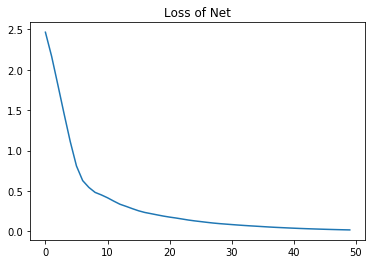

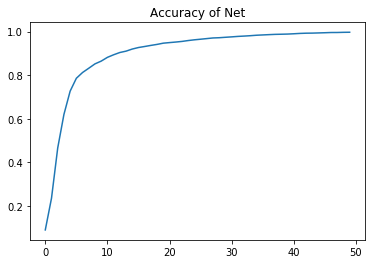

In [265]:
lss, acc = train(torch.relu, 50)
graph("Loss of Net", lss)
graph("Accuracy of Net", acc)


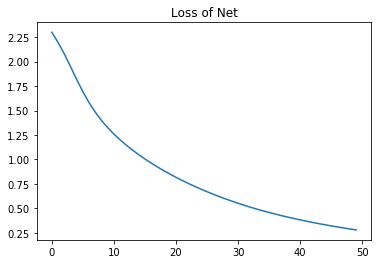

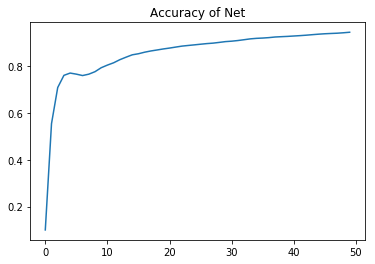

In [266]:
lss, acc = train(torch.tanh, 50)
graph("Loss of Net", lss)
graph("Accuracy of Net", acc)


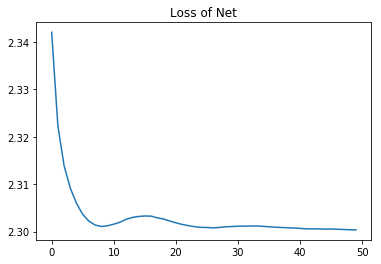

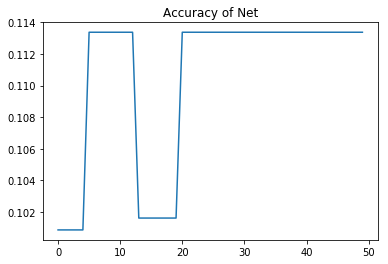

In [267]:
lss, acc = train(torch.sigmoid, 50)
graph("Loss of Net", lss)
graph("Accuracy of Net", acc)
